In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
data = pd.read_csv('segmentation_data.csv')
data.shape

(8068, 11)

In [33]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [34]:
numeric_columns = data.loc[:, data.dtypes != object].columns
data.loc[:, data.dtypes != object].head(2)

,ID,Age,Work_Experience,Family_Size
0,462809,22,1.0,4.0
1,462643,38,NaN,3.0


In [35]:
data = data.set_index('ID')
numeric_columns = numeric_columns.drop('ID')

In [36]:
categorical_columns = data.loc[:,data.dtypes == object].columns
data[categorical_columns].head(2)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
ID,,,,,,,
462809,Male,No,No,Healthcare,Low,Cat_4,D
462643,Female,Yes,Yes,Engineer,Average,Cat_4,A


# EDA

In [37]:
data.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


# Обработка вещественных признаков

In [38]:
# Заполним пропуски в вещественных колонках средним
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].mean())

In [39]:
data[numeric_columns].isna().sum()

Age                0
Work_Experience    0
Family_Size        0
dtype: int64

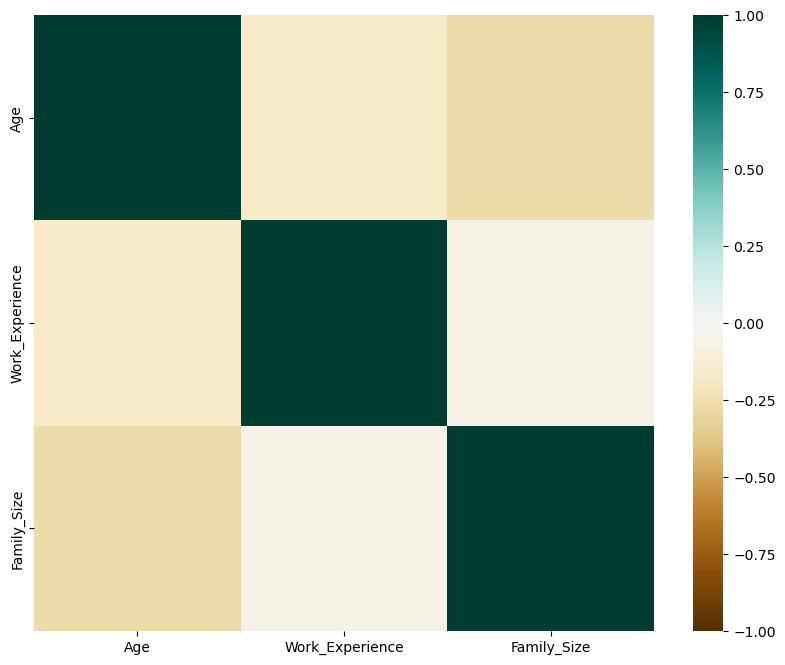

In [40]:
import seaborn as sns
fig = plt.figure()
fig.set_size_inches(10,8)
sns.heatmap(data[numeric_columns].corr(),
            xticklabels = numeric_columns,
            yticklabels = numeric_columns,
            cmap = 'BrBG',
            vmin = -1,
            vmax = +1
)
plt.show()

In [41]:
def get_redundant_pairs(data):
    pairs_to_drop = set()
    cols = data.columns
    for i in range(data.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlation(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]
    
print('Top Absolute Correlations')
print(get_top_abs_correlation(data[numeric_columns],10))

Top Absolute Correlations
Age              Family_Size        0.273291
                 Work_Experience    0.179361
Work_Experience  Family_Size        0.058702
dtype: float64


In [42]:
# Посмотрим на квазиконстантные признаки
from sklearn.feature_selection import VarianceThreshold

cutter = VarianceThreshold(threshold = 0.1)
cutter.fit(data[numeric_columns])

cutter.get_feature_names_out()

array(['Age', 'Work_Experience', 'Family_Size'], dtype=object)

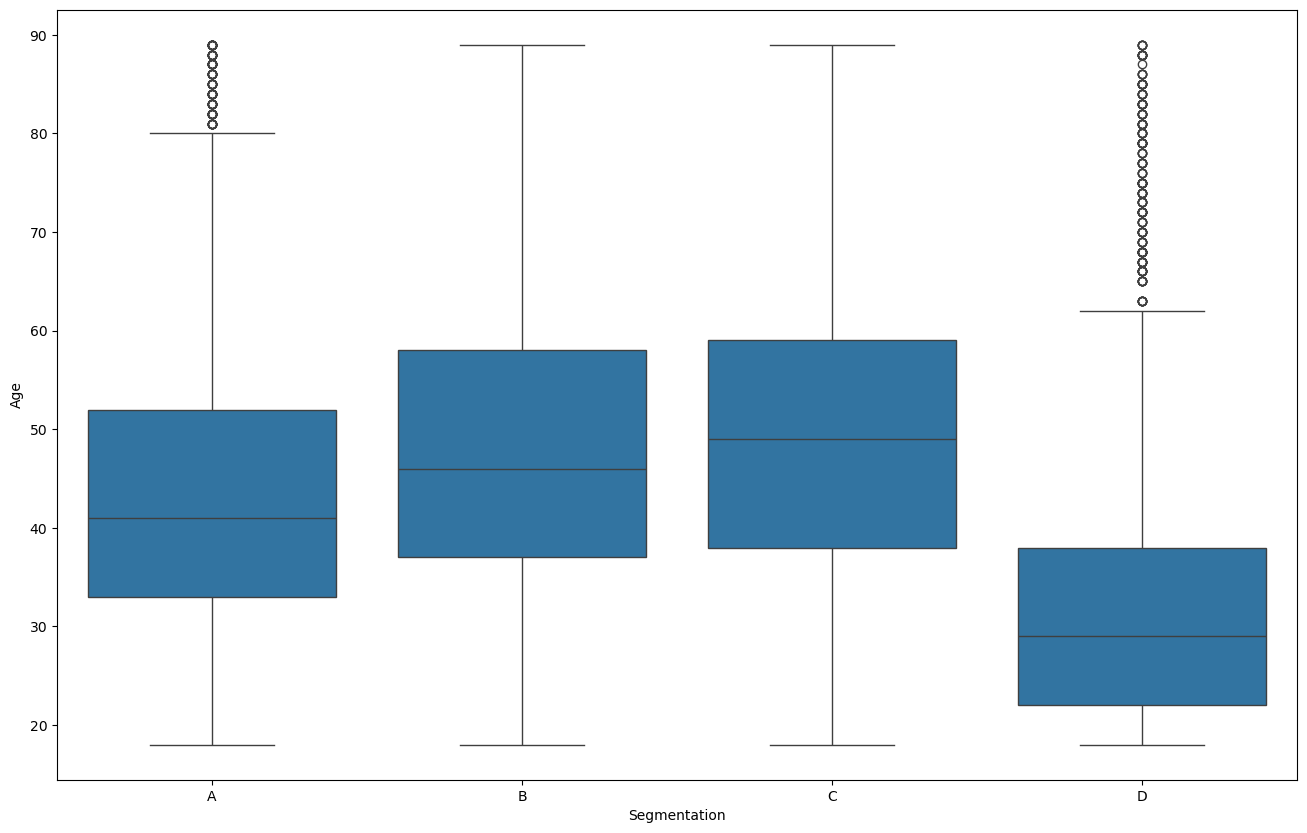

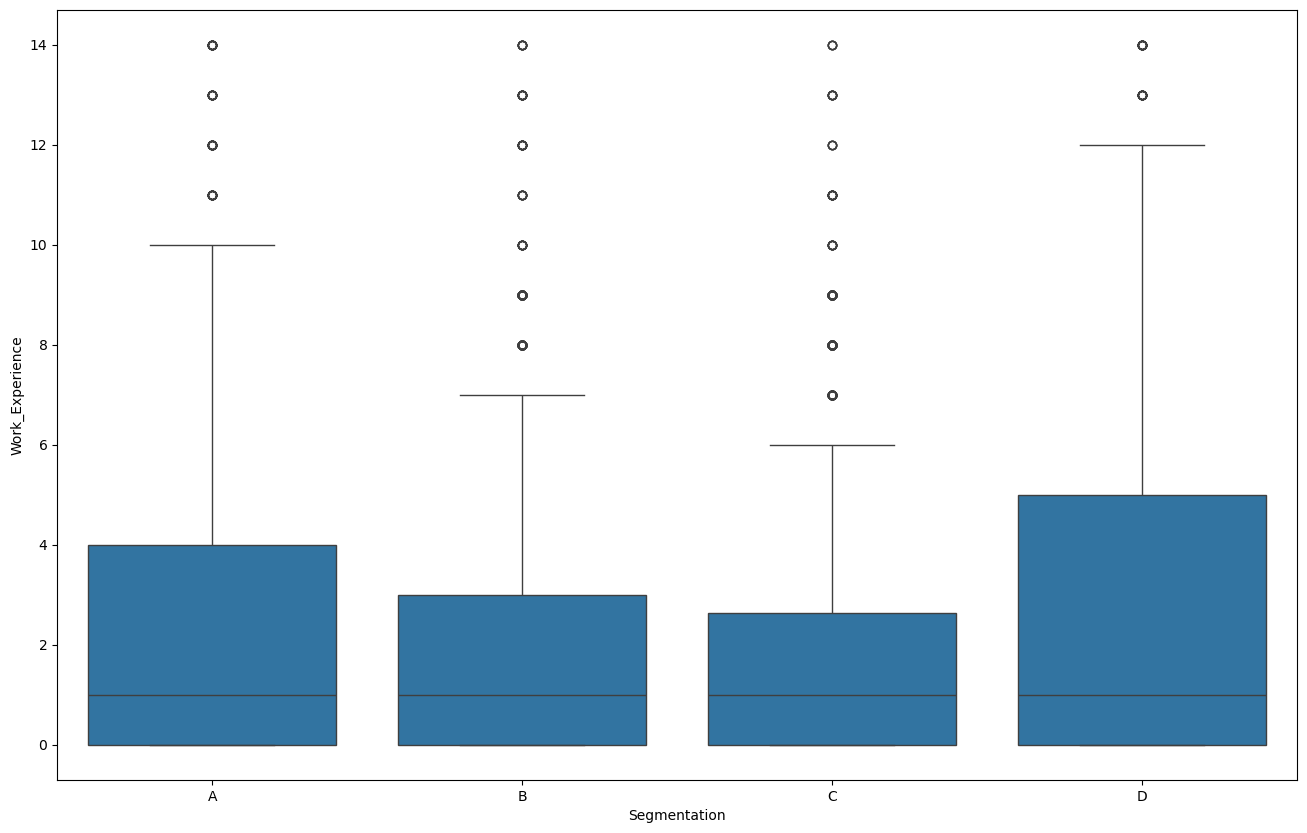

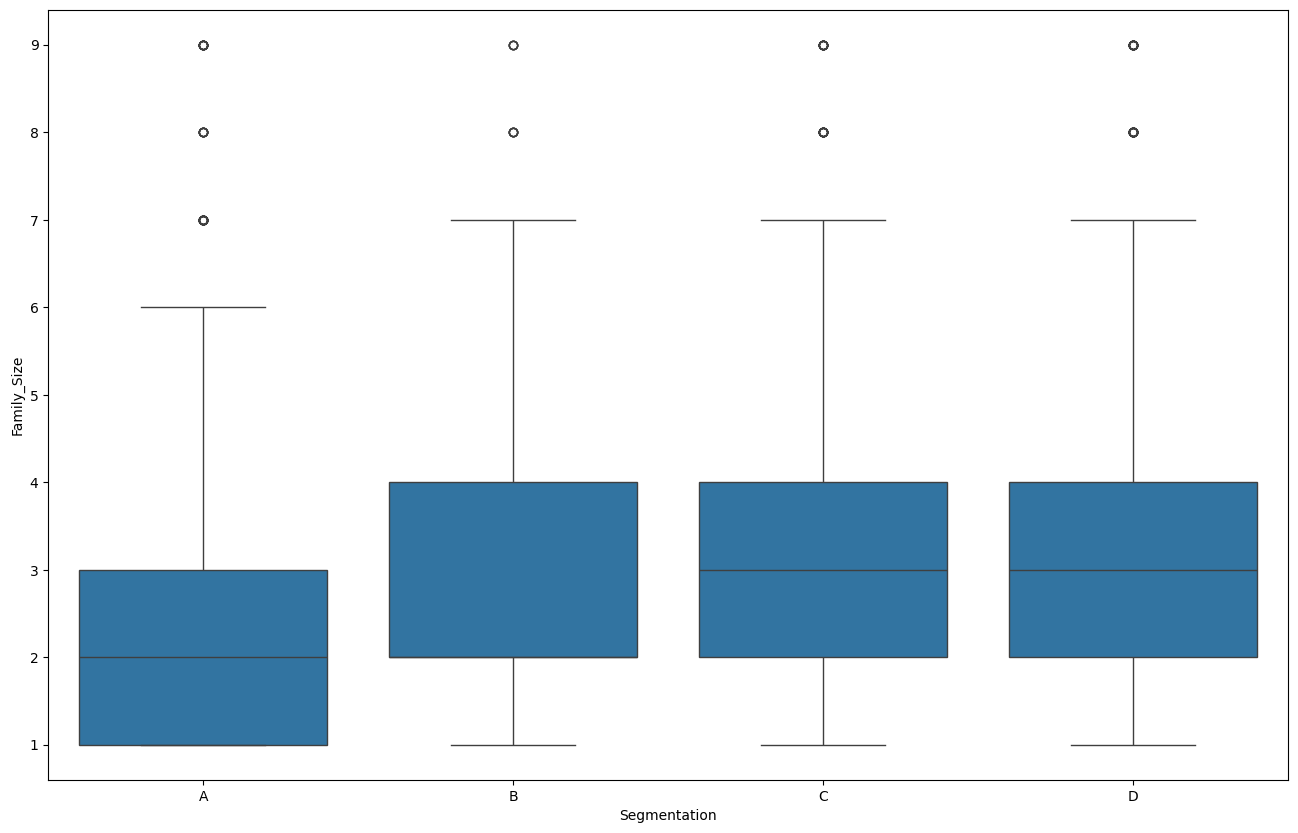

In [43]:
# Визуализация распределения таргета
# Рисуем ящики с усами

for col in numeric_columns:
    fig = plt.figure()
    fig.set_size_inches(16,10)
    sns.boxplot(y = col, x = data['Segmentation'].astype('category'), data = data)
    plt.show()


# Обработка категориальных признаков

In [44]:
categorical_columns = data.loc[:, data.dtypes == object].columns
data.describe(include = object)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


In [45]:
# Заполним пропуски в категориальных колонках
for col in categorical_columns:
    most_popular = data.groupby(col).size().sort_values().index[-1]
    data[col] = data[col].fillna(most_popular)

data.describe(include = object)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


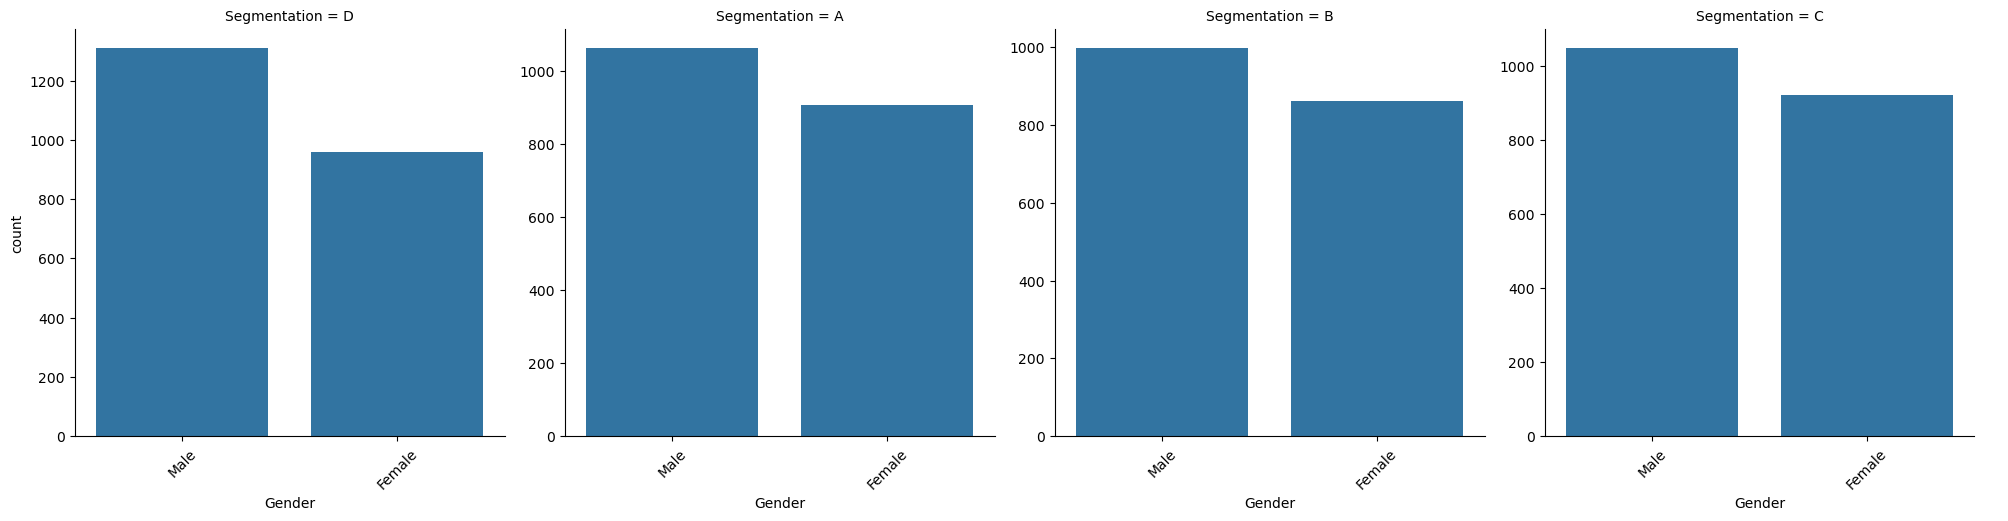

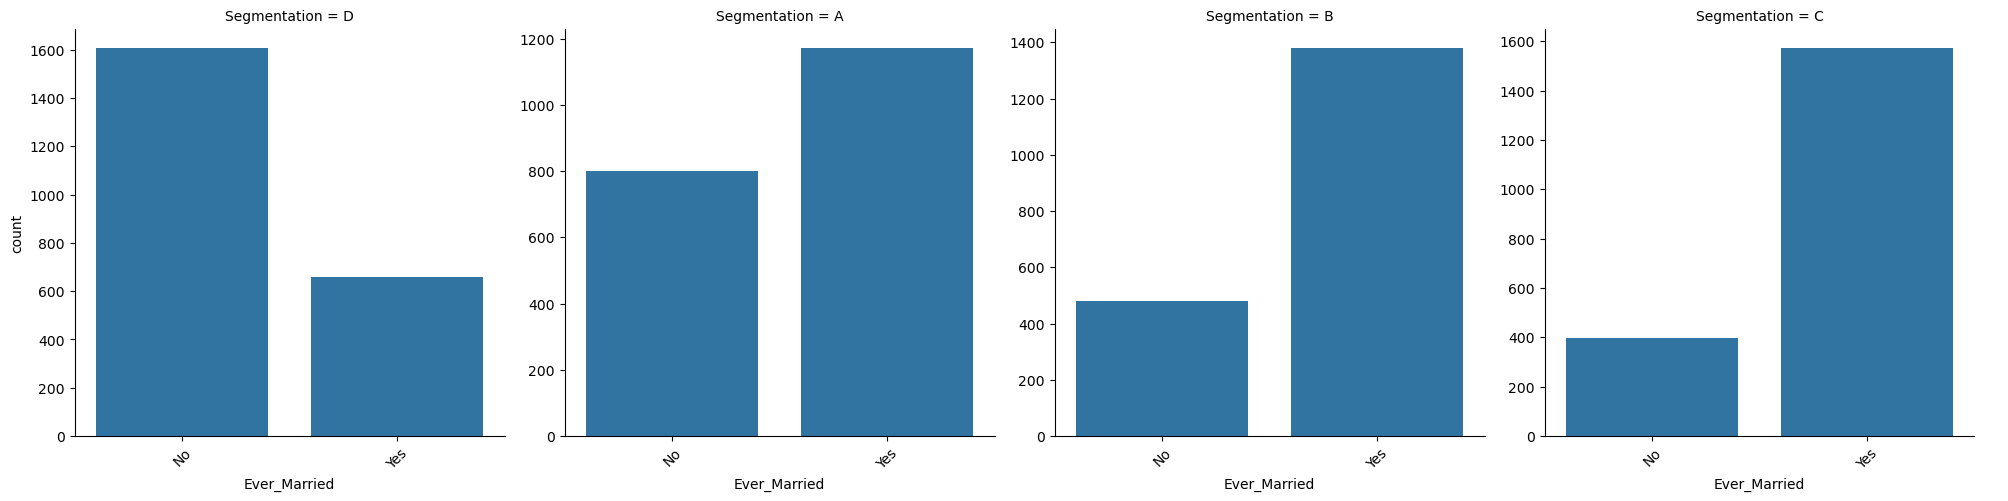

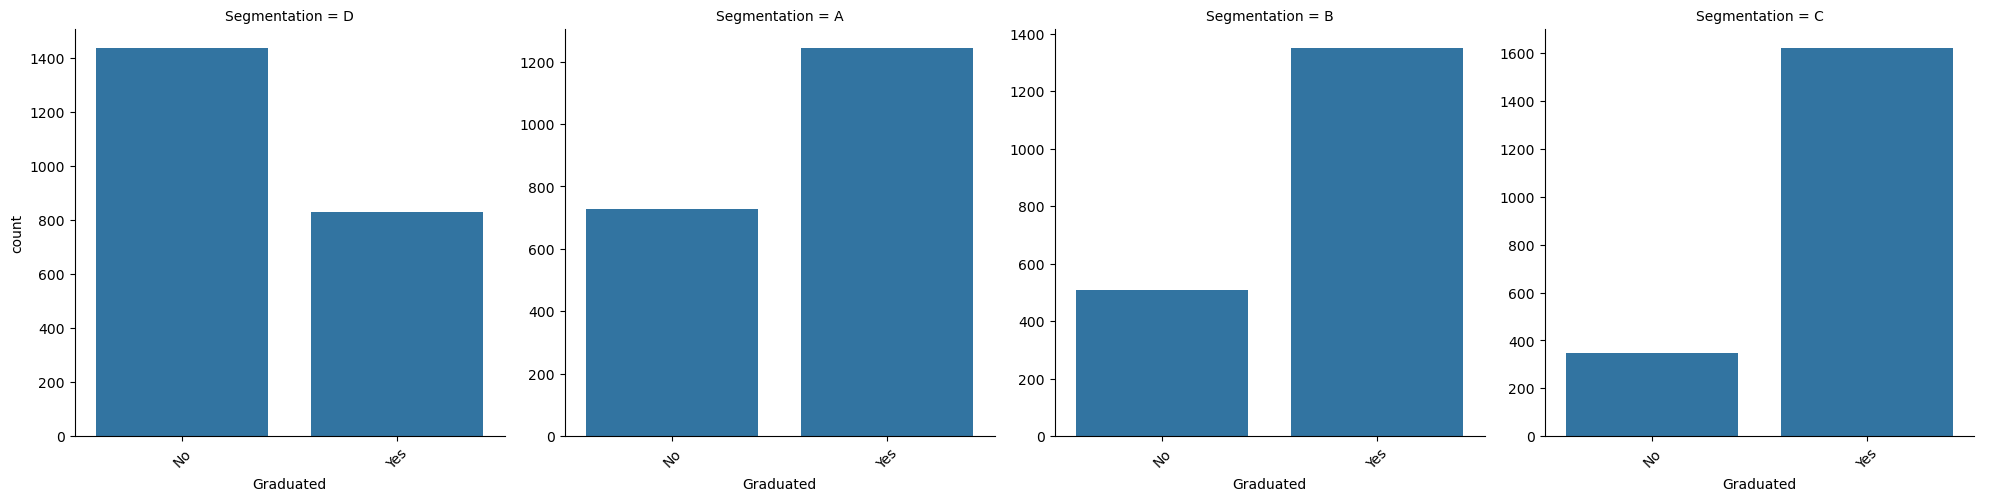

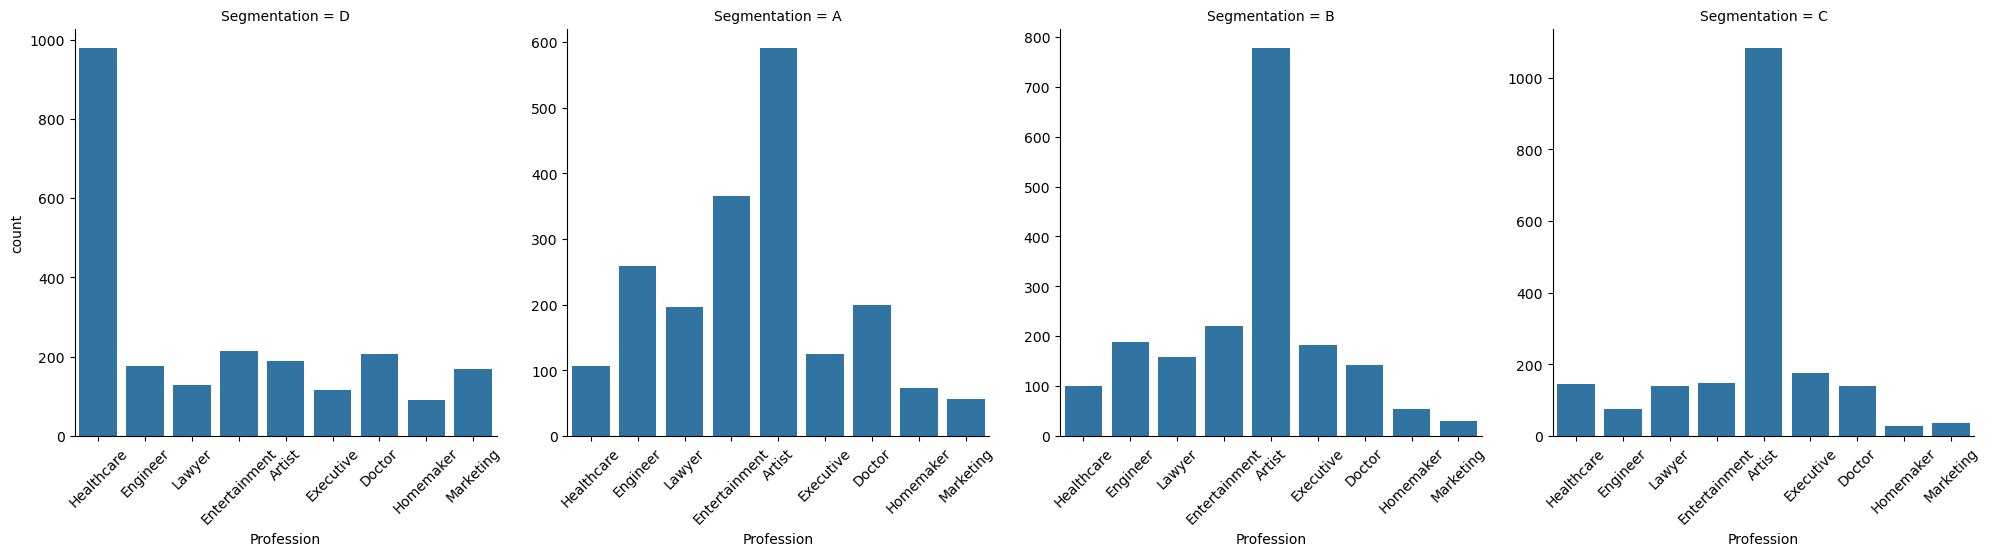

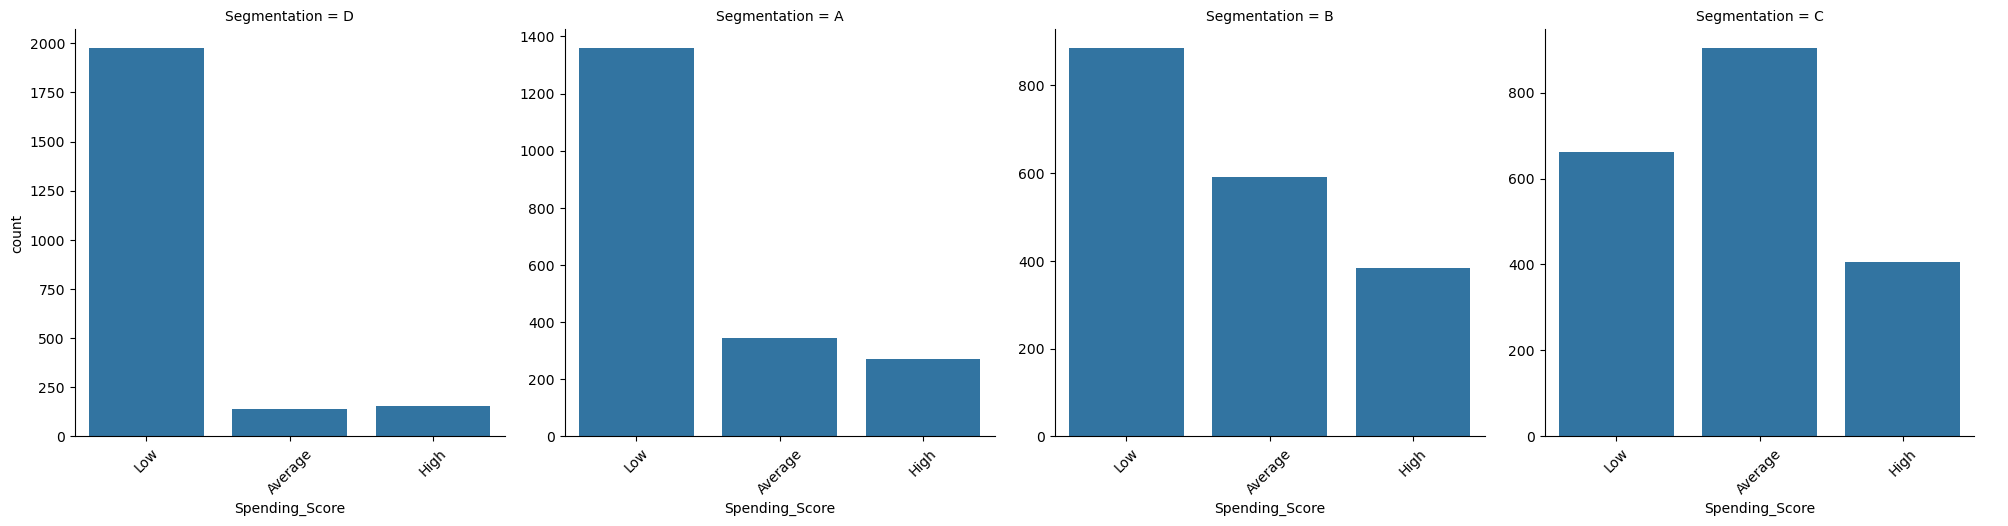

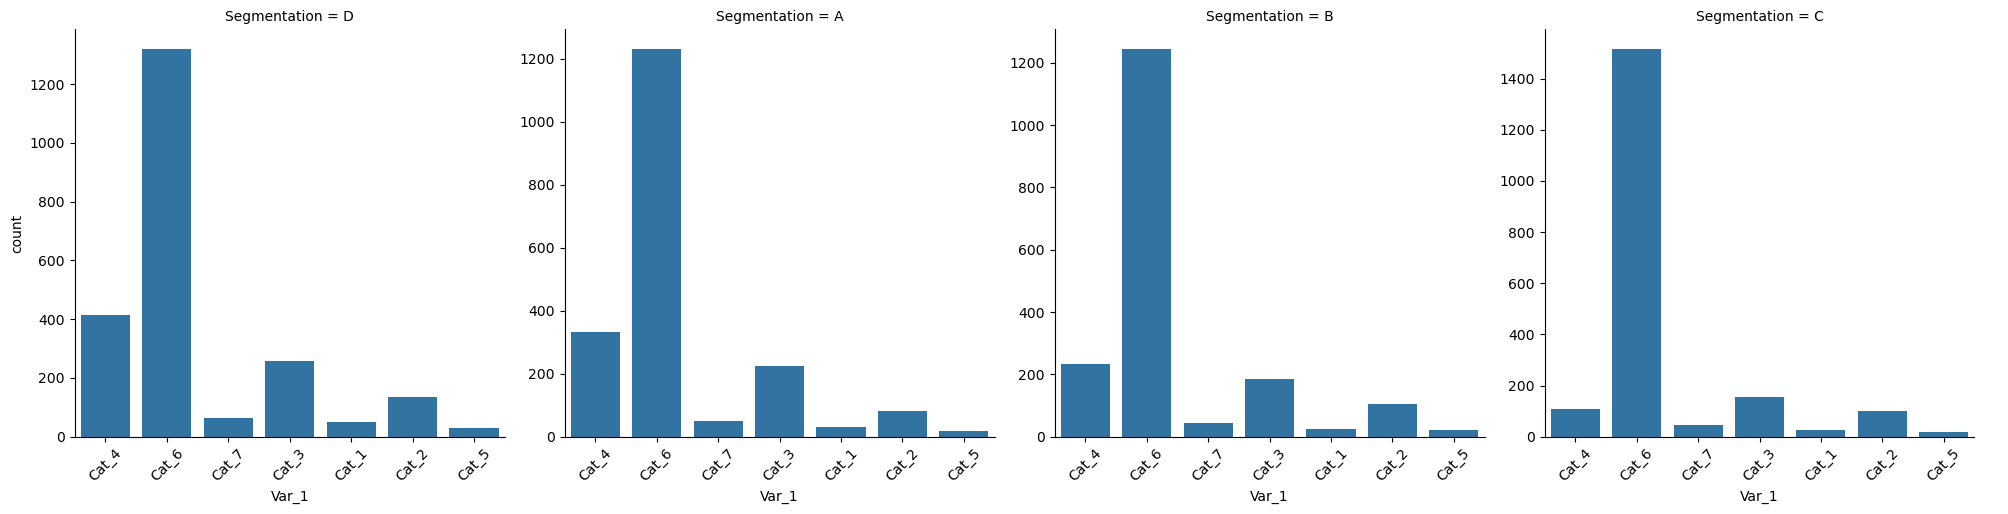

In [46]:
for col in categorical_columns:
    if col != 'Segmentation':
        g = sns.catplot(x = col, data = data, kind = 'count', col = 'Segmentation', sharey = False)
        g.set_xticklabels(rotation = 45)

# Закодируем категориальные фичи

In [47]:
data.describe(include = object)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


In [48]:
def encode_multiclass_target(data, category, target = 'Segmentation'):
    df = data[[category, target]].copy()

    one_hot = pd.get_dummies(df[target], prefix = category, drop_first = True)
    df = pd.concat((df, one_hot), axis = 1)
    for tg in one_hot.columns:
        df[tg] = df.groupby(category)[tg].transform('mean')

    return df.drop(category, axis = 1)

In [49]:
encode_multiclass_target(data, 'Gender')

,Segmentation,Gender_B,Gender_C,Gender_D
ID,,,,
462809,D,0.225719,0.237265,0.296355
462643,A,0.235826,0.252534,0.262668
466315,B,0.235826,0.252534,0.262668
461735,B,0.225719,0.237265,0.296355
462669,A,0.235826,0.252534,0.262668
...,...,...,...,...
464018,D,0.225719,0.237265,0.296355
464685,D,0.225719,0.237265,0.296355
465406,D,0.235826,0.252534,0.262668


In [50]:
data.describe(include = object)

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


In [51]:
mean_targets = {}
for col in categorical_columns.drop('Segmentation'):
    if data[col].nunique()<4:
        one_hot = pd.get_dummies(data[col], prefix = col, drop_first = True)
        data = pd.concat((data.drop(col, axis = 1), one_hot), axis = 1)
    else:
        mean_target = encode_multiclass_target(data, col).drop('Segmentation', axis = 1)
        mean_targets[col] = mean_target
        data = pd.concat((data.drop(col, axis = 1), mean_targets[col]), axis = 1)

In [52]:
data = data*1
data

,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
ID,,,,,,,,,,,,,,,
462809,22,1.000000,4.0,D,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084
462643,38,2.641663,3.0,A,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084
466315,67,1.000000,1.0,B,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400
461735,67,0.000000,2.0,B,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400
462669,40,2.641663,6.0,A,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464018,22,0.000000,7.0,D,1,0,0,0.294697,0.410227,0.071212,0,1,0.195489,0.195489,0.375940
464685,35,3.000000,4.0,D,1,0,0,0.305509,0.292154,0.193656,0,1,0.213039,0.100092,0.381084
465406,33,1.000000,1.0,D,0,0,1,0.075826,0.109610,0.734985,0,1,0.234287,0.285472,0.248400


In [61]:
X = data.drop('Segmentation', axis = 1)
Y = data['Segmentation']

### PCA

In [91]:
# Центрируем данные
X = X.subtract(X.mean())
X.head()

,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
ID,,,,,,,,,,,,,,
462809,-21.466906,-1.641663e+00,1.149877,0.452529,-0.592836,-0.625434,-0.154467,-0.134565,0.453874,-0.150719,0.395389,-0.017253,-0.144083,0.099973
462643,-5.466906,2.518781e-16,0.149877,-0.547471,0.407164,0.374566,0.040094,-0.136878,-0.029322,-0.150719,-0.604611,-0.017253,-0.144083,0.099973
466315,23.533094,-1.641663e+00,-1.850123,-0.547471,0.407164,0.374566,0.040094,-0.136878,-0.029322,-0.150719,0.395389,0.003994,0.041298,-0.032710
461735,23.533094,-2.641663e+00,-0.850123,0.452529,0.407164,0.374566,0.023319,-0.019455,-0.075653,0.849281,-0.604611,0.003994,0.041298,-0.032710
462669,-3.466906,2.518781e-16,3.149877,-0.547471,0.407164,0.374566,0.002584,-0.088221,-0.054556,0.849281,-0.604611,0.003994,0.041298,-0.032710


In [92]:
X.shape

(8068, 14)

In [93]:
# Разделим X на 2 компоненты
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
PCA_dataset = pca.fit_transform(X)
PCA_dataset = pd.DataFrame(PCA_dataset, columns = ['PCA_1', 'PCA_2'])
PCA_dataset.shape

(8068, 2)

In [94]:
PCA_dataset.isna().sum()

PCA_1    0
PCA_2    0
dtype: int64

In [99]:
# Как связаны новые признаки со старыми
check_corr = pd.concat((X.reset_index(drop = True),PCA_dataset), axis = 1)
first_component_corr = check_corr.corr().loc['PCA_1']
second_component_corr = check_corr.corr().loc['PCA_2']

corrs = pd.concat((first_component_corr, second_component_corr), axis = 1)


,PCA_1,PCA_2
Age,9.999764e-01,6.465474e-03
Work_Experience,-1.857811e-01,9.821512e-01
Family_Size,-2.744964e-01,-1.400779e-01
Gender_Male,3.051643e-02,-5.511275e-02
Ever_Married_Yes,5.571748e-01,1.147395e-02
Graduated_Yes,2.358373e-01,8.230031e-02
Profession_B,4.576191e-01,8.092515e-02
Profession_C,2.811300e-01,3.426457e-02
Profession_D,-4.544625e-01,-7.653966e-02
Spending_Score_High,3.607438e-01,9.405703e-04


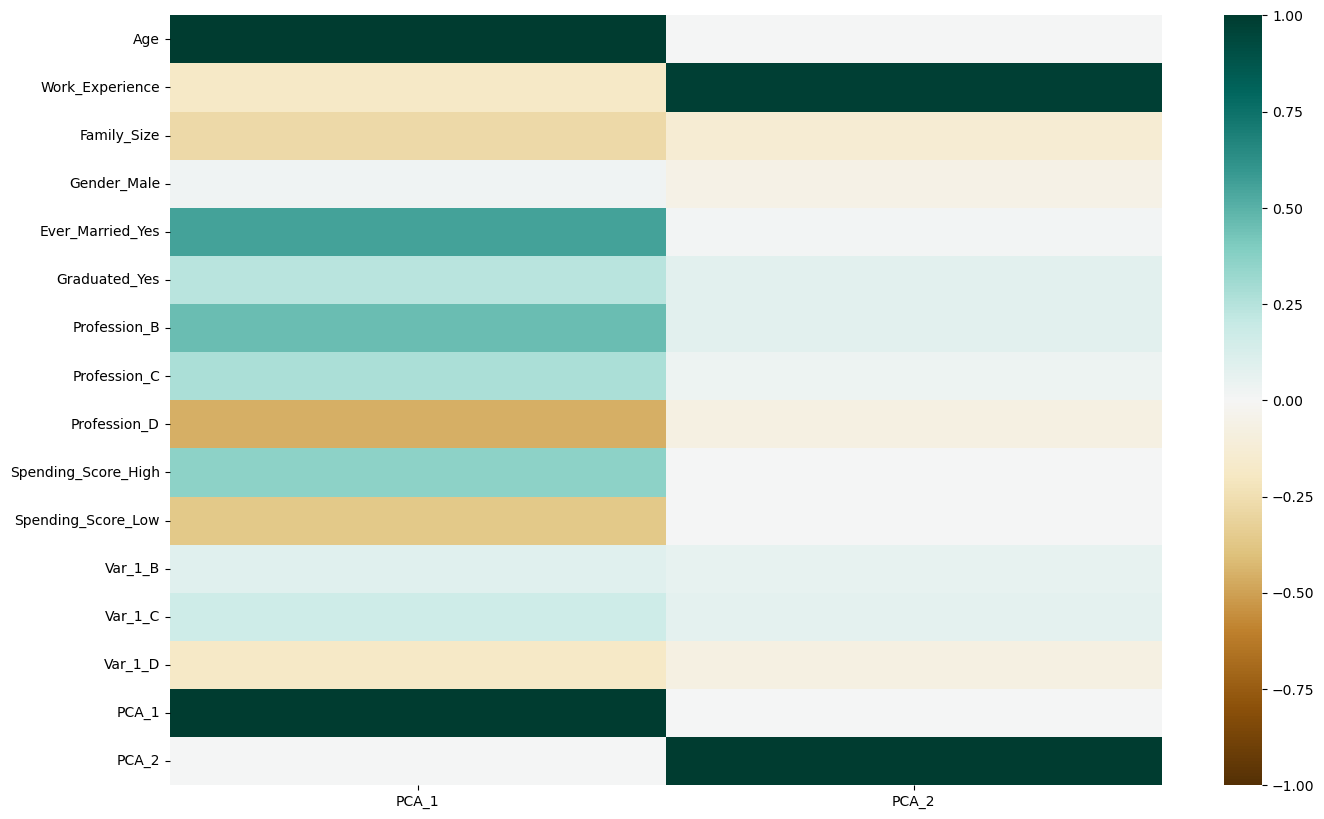

In [100]:
fig = plt.figure()
fig.set_size_inches(16,10)

sns.heatmap(corrs,
           xticklabels = corrs.columns,
           yticklabels = corrs.index,
           cmap = 'BrBG',
           vmin = -1,
           vmax = 1)

plt.show()

In [101]:
# Объединим с таргетом

PCA_dataset = np.concatenate((PCA_dataset.values, Y.values.reshape(-1,1)), axis = 1)
PCA_dataset = pd.DataFrame(PCA_dataset, columns = ['PCA_1', 'PCA_2', 'SEGMENT'])

In [102]:
PCA_dataset

,PCA_1,PCA_2,SEGMENT
0,-21.43287,-2.45872,D
1,-5.450097,-0.185937,A
2,23.612201,-0.704385,B
3,23.643254,-1.775789,B
4,-3.51823,-0.315505,A
...,...,...,...
8063,-21.465477,-3.649337,D
8064,-8.516026,-0.018887,D
8065,-10.366329,-1.864995,D
8066,-16.432833,-2.267166,B


<Axes: xlabel='PCA_1', ylabel='PCA_2'>

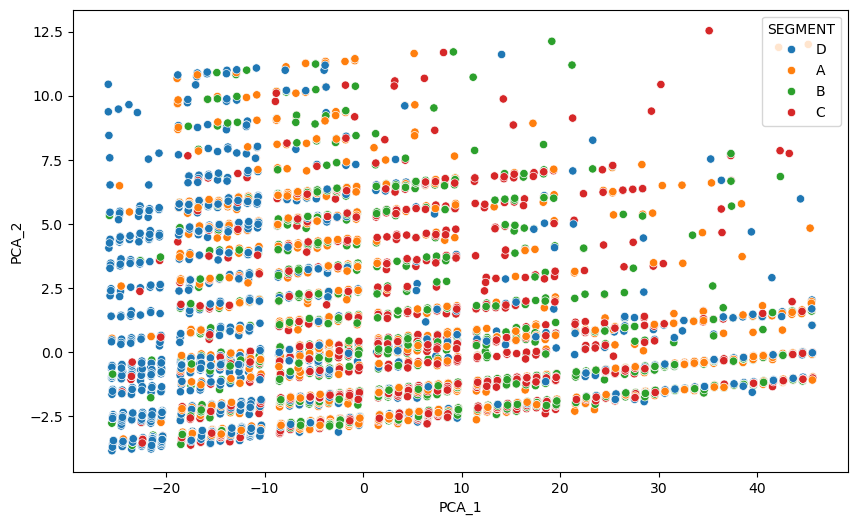

In [104]:
fig = plt.figure()
fig.set_size_inches(10,6)
sns.scatterplot(data = PCA_dataset, x = 'PCA_1', y = 'PCA_2', hue='SEGMENT')

In [119]:
# Разделим X на 3 компоненты
from sklearn.decomposition import PCA
pca_3d = PCA(n_components = 3)
PCA_3d_dataset = pca_3d.fit_transform(X)
PCA_3d_dataset = pd.DataFrame(PCA_3d_dataset, columns = ['PCA_1', 'PCA_2', 'PCA_3'])
PCA_3d_dataset.shape

(8068, 3)

In [120]:
PCA_3d_dataset.isna().sum()

PCA_1    0
PCA_2    0
PCA_3    0
dtype: int64

In [121]:
# Как связаны новые признаки со старыми
check_corr = pd.concat((X.reset_index(drop = True),PCA_3d_dataset), axis = 1)
first_component_corr = check_corr.corr().loc['PCA_1']
second_component_corr = check_corr.corr().loc['PCA_2']
third_component_corr = check_corr.corr().loc['PCA_3']

corrs = pd.concat((first_component_corr, second_component_corr, third_component_corr), axis = 1)


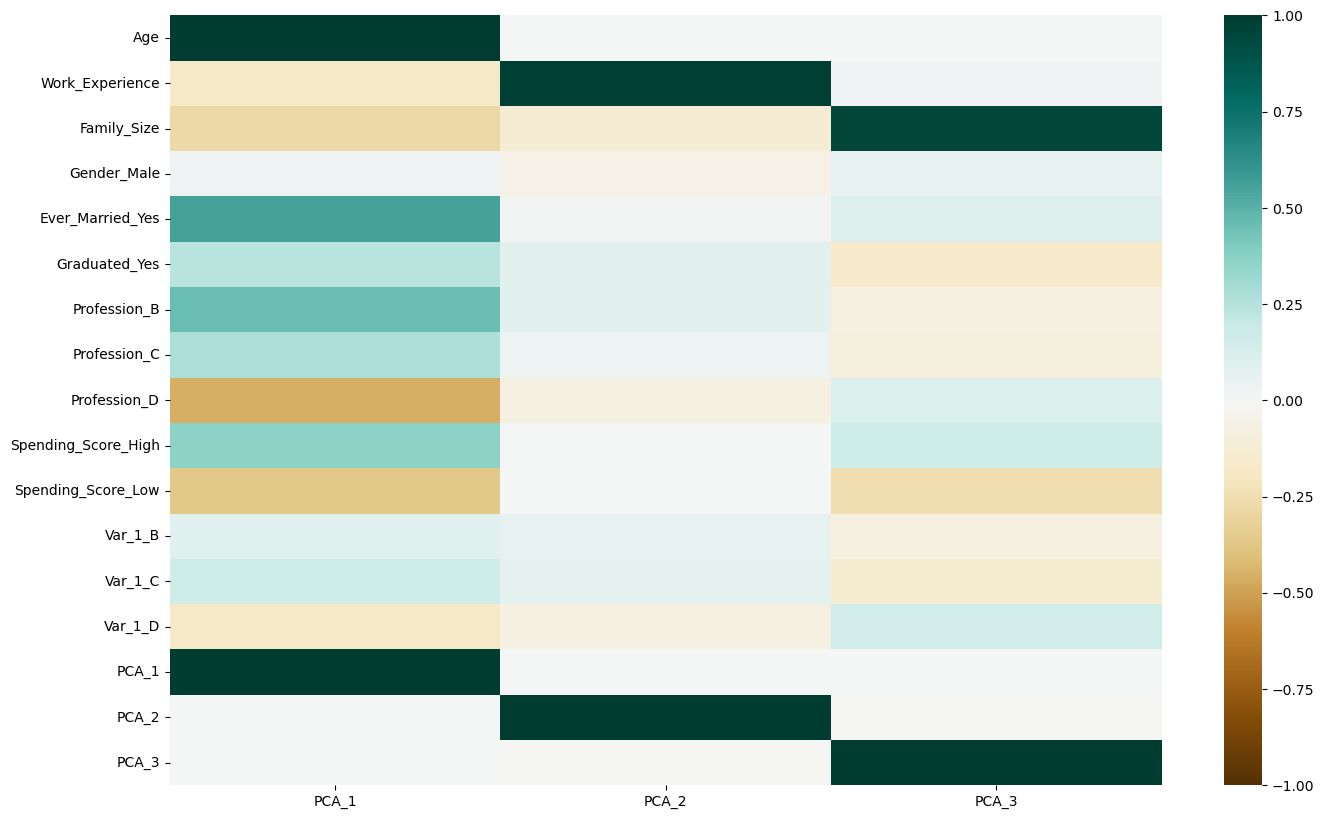

In [122]:
fig = plt.figure()
fig.set_size_inches(16,10)

sns.heatmap(corrs,
           xticklabels = corrs.columns,
           yticklabels = corrs.index,
           cmap = 'BrBG',
           vmin = -1,
           vmax = 1)

plt.show()

In [123]:
# Объединим с таргетом
PCA_3d_dataset = np.concatenate((PCA_3d_dataset.values, Y.values.reshape(-1,1)), axis = 1)
PCA_3d_dataset = pd.DataFrame(PCA_3d_dataset, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'SEGMENT'])

In [129]:
PCA_3d_dataset['PCA_1'] = PCA_3d_dataset['PCA_1'].astype('float64')
PCA_3d_dataset['PCA_2'] = PCA_3d_dataset['PCA_2'].astype('float64')
PCA_3d_dataset['PCA_3'] = PCA_3d_dataset['PCA_3'].astype('float64')


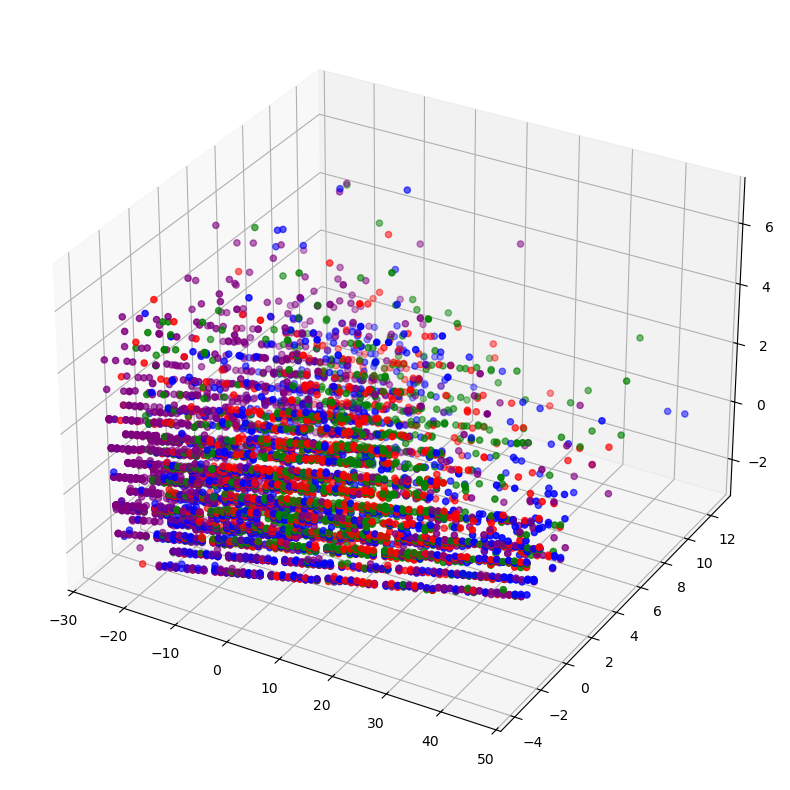

In [130]:
fig = plt.figure()
fig.set_size_inches(16,10)
ax = plt.axes(projection = '3d')
colors = PCA_3d_dataset['SEGMENT'].replace(['A','B','C','D'],
                                          ['blue','red','green','purple'])
ax.scatter3D(PCA_3d_dataset['PCA_1'],
            PCA_3d_dataset['PCA_2'],
            PCA_3d_dataset['PCA_3'],
            c = colors)
plt.show()

In [134]:
# Исходный датасет
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

import datetime

pipe = Pipeline([('scaler', StandardScaler()),
                ('classifier', OneVsRestClassifier(estimator = SGDClassifier()))])
begin_time = datetime.datetime.now()
pipe.fit(X, Y)
end_time = datetime.datetime.now()
print(end_time - begin_time)
print(pipe.score(X, Y))

0:00:00.358033
0.4765741199801686


In [137]:
# Применения PCA (метод главных компонент)
pipe = Pipeline([('scaler', StandardScaler()),
                ('classifier', OneVsRestClassifier(estimator = SGDClassifier()))])
begin_time = datetime.datetime.now()
pipe.fit(PCA_3d_dataset.drop('SEGMENT', axis = 1), Y)
end_time = datetime.datetime.now()
print(end_time - begin_time)
print(pipe.score(PCA_3d_dataset.drop('SEGMENT', axis = 1), Y))

0:00:00.159058
0.34345562716906297


In [150]:
# Замерим качество для разного колтчества компонент

score_dict = {}
time_dict = {}

for power in range(1,11):
    pca_dataset = PCA(n_components = power).fit_transform(X)
    begin_time = datetime.datetime.now()
    pipe.fit(pca_dataset, Y)
    end_time = datetime.datetime.now()
    time_dict[power] = (end_time - begin_time).microseconds
    score_dict[power] = pipe.score(pca_dataset, Y)

In [151]:
time_dict

{1: 158752,
 2: 167440,
 3: 170415,
 4: 215482,
 5: 236203,
 6: 264893,
 7: 266228,
 8: 271221,
 9: 294602,
 10: 367623}

In [152]:
score_dict

{1: 0.34494298463063955,
 2: 0.3533713435795736,
 3: 0.4112543381259296,
 4: 0.3616757560733763,
 5: 0.40208230044620724,
 6: 0.44038175508180466,
 7: 0.43381259295984137,
 8: 0.45599900842835894,
 9: 0.4319533961328706,
 10: 0.4577342588001983}

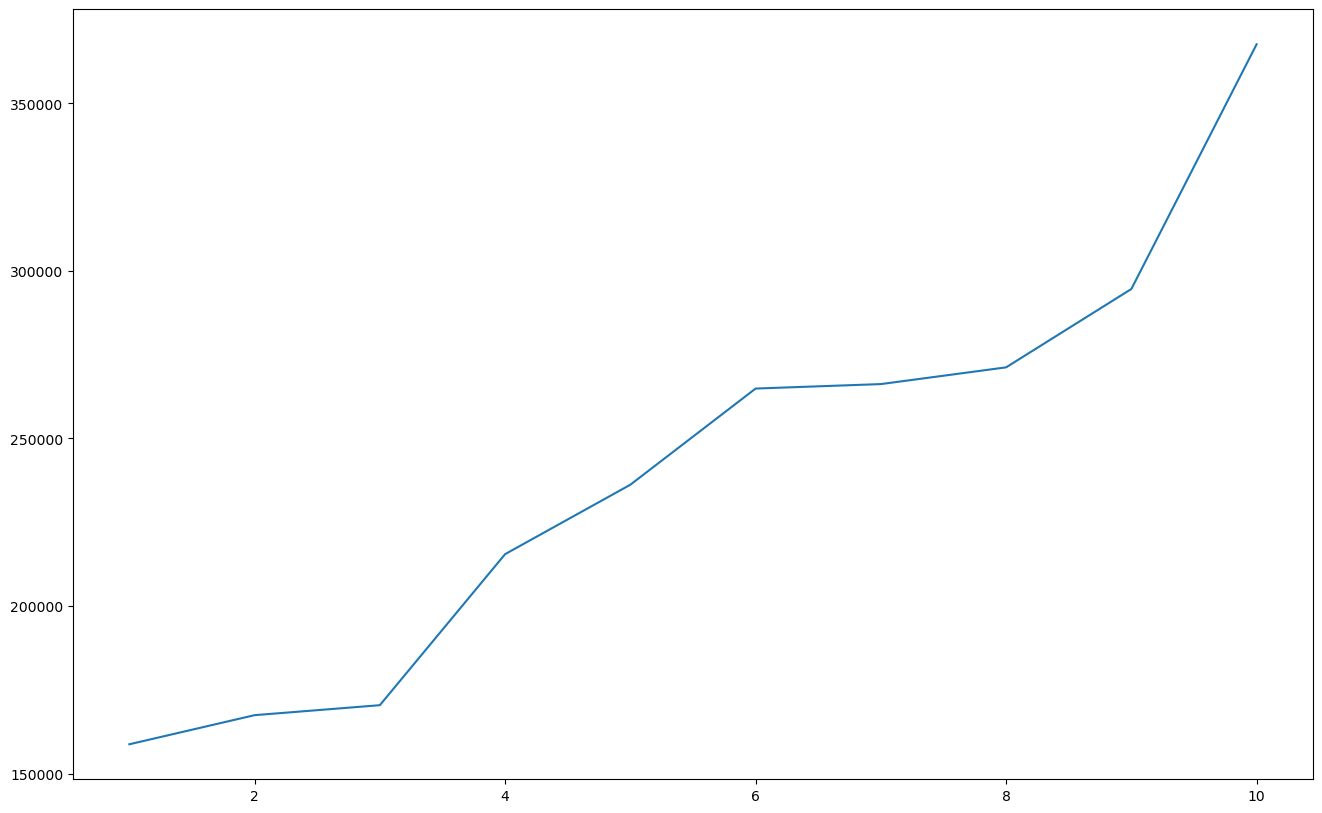

In [153]:
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot(time_dict.keys(), time_dict.values())
plt.show()

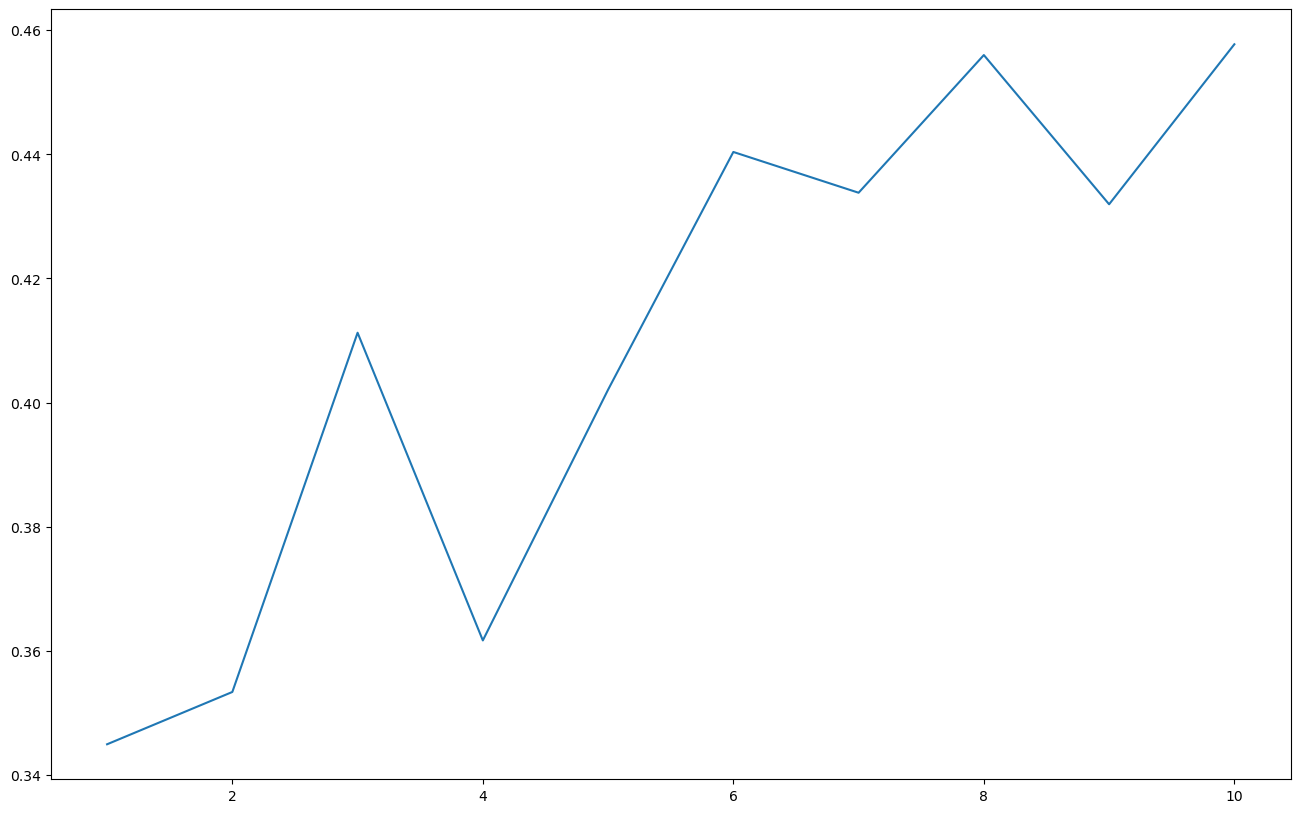

In [154]:
fig = plt.figure()
fig.set_size_inches(16,10)
plt.plot(score_dict.keys(), score_dict.values())
plt.show()

In [156]:
# t-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components = 2).fit_transform(X)
X_tsne

array([[-85.359825  ,   8.018129  ],
       [ -0.7663168 ,  15.838959  ],
       [ 42.35446   ,   9.849802  ],
       ...,
       [-22.346327  , -40.05777   ],
       [-61.02674   , -43.923264  ],
       [ -9.9462805 ,   0.21413781]], dtype=float32)

In [157]:
X_tsne = np.concatenate((X_tsne, Y.values.reshape(-1,1)), axis = 1)
X_tsne = pd.DataFrame(X_tsne, columns = ['TSNE_1','TSNE_2','SEGMENT'])

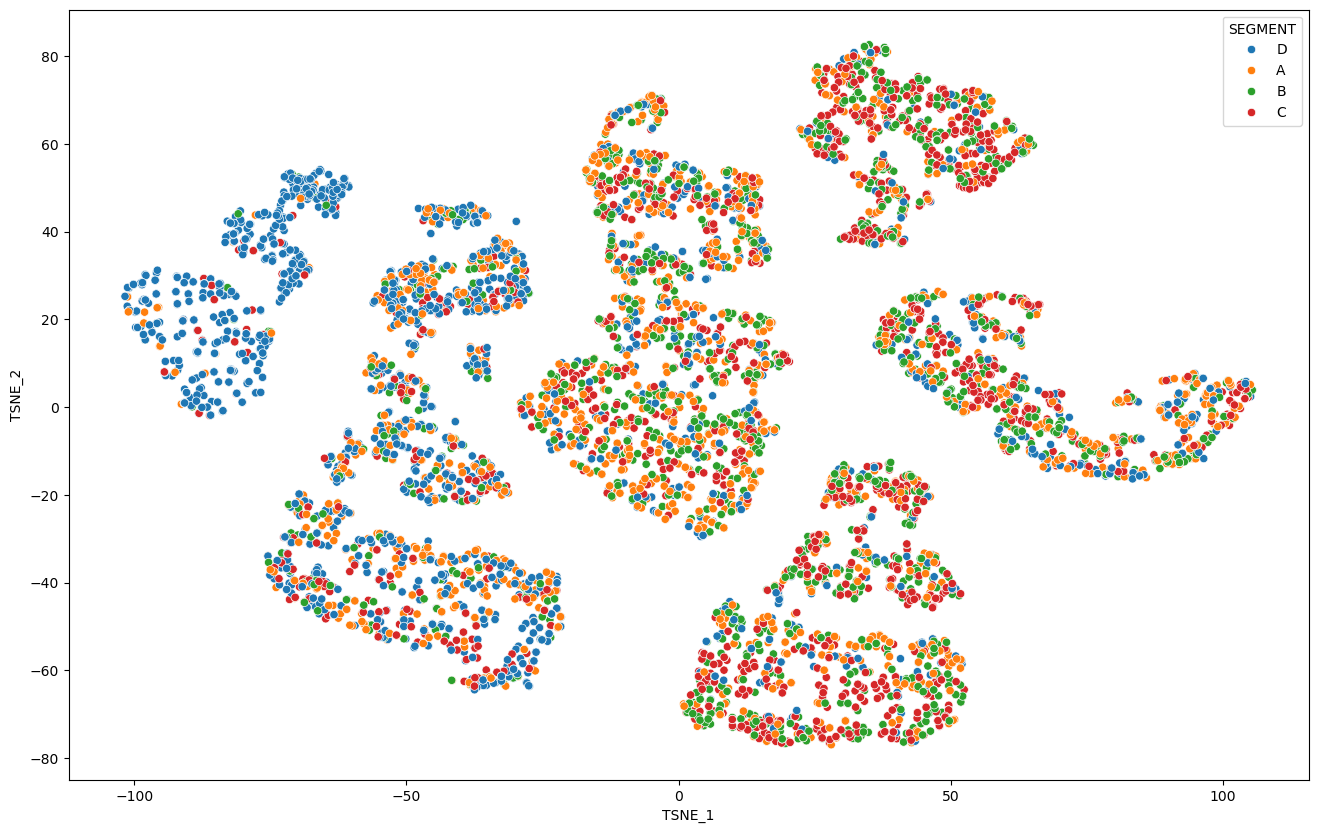

In [159]:
fig = plt.figure()
fig.set_size_inches(16,10)
sns.scatterplot(data = X_tsne, x = X_tsne['TSNE_1'],y = X_tsne['TSNE_2'],hue = X_tsne['SEGMENT'])
plt.show()

In [165]:
X_tsne_3d = TSNE(n_components = 3).fit_transform(X)
X_tsne_3d = np.concatenate((X_tsne_3d, Y.values.reshape(-1,1)), axis = 1)
X_tsne_3d = pd.DataFrame(X_tsne_3d, columns = ['TSNE_1','TSNE_2', 'TSNE_3','SEGMENT'])

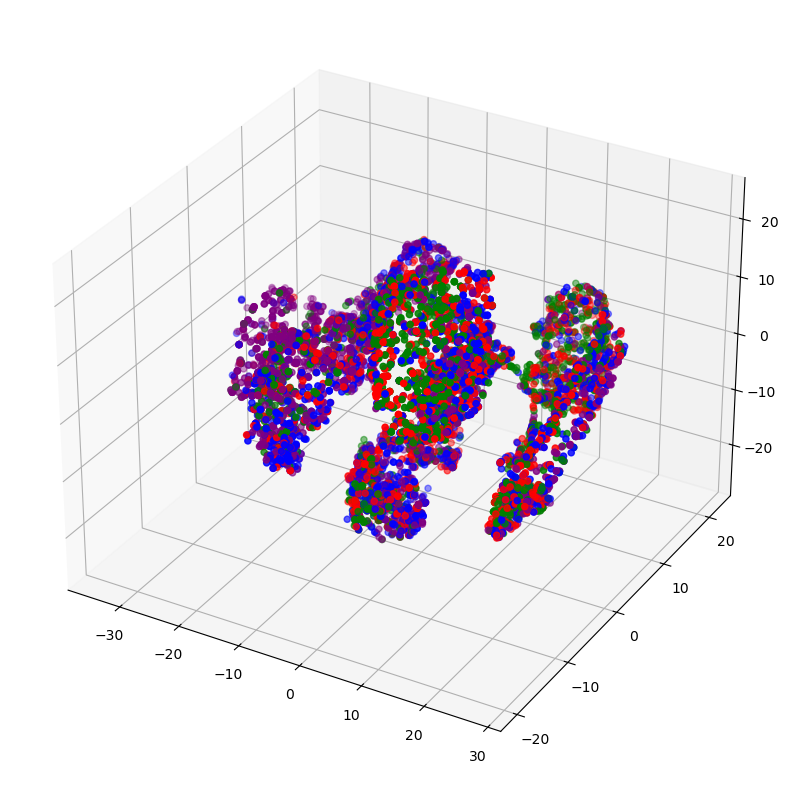

In [168]:
fig = plt.figure()
fig.set_size_inches(16,10)
ax = plt.axes(projection = '3d')
colors = X_tsne_3d['SEGMENT'].replace(['A','B','C','D'],
                                     ['blue','red','green','purple'])
X_tsne_3d['TSNE_1'] = X_tsne_3d['TSNE_1'].astype('float64')
X_tsne_3d['TSNE_2'] = X_tsne_3d['TSNE_2'].astype('float64')
X_tsne_3d['TSNE_3'] = X_tsne_3d['TSNE_3'].astype('float64')

ax.scatter3D(X_tsne_3d['TSNE_1'],
            X_tsne_3d['TSNE_2'],
            X_tsne_3d['TSNE_3'],
            c = colors)
plt.show()

In [167]:
pipe = Pipeline([('scaler', StandardScaler()),
                ('classifier', OneVsRestClassifier(estimator = SGDClassifier()))])
begin_time = datetime.datetime.now()
pipe.fit(X_tsne_3d.drop('SEGMENT', axis = 1), Y)
end_time = datetime.datetime.now()
print(end_time - begin_time)
print(pipe.score(X_tsne_3d.drop('SEGMENT', axis = 1), Y))

0:00:00.186596
0.39600892414476946
